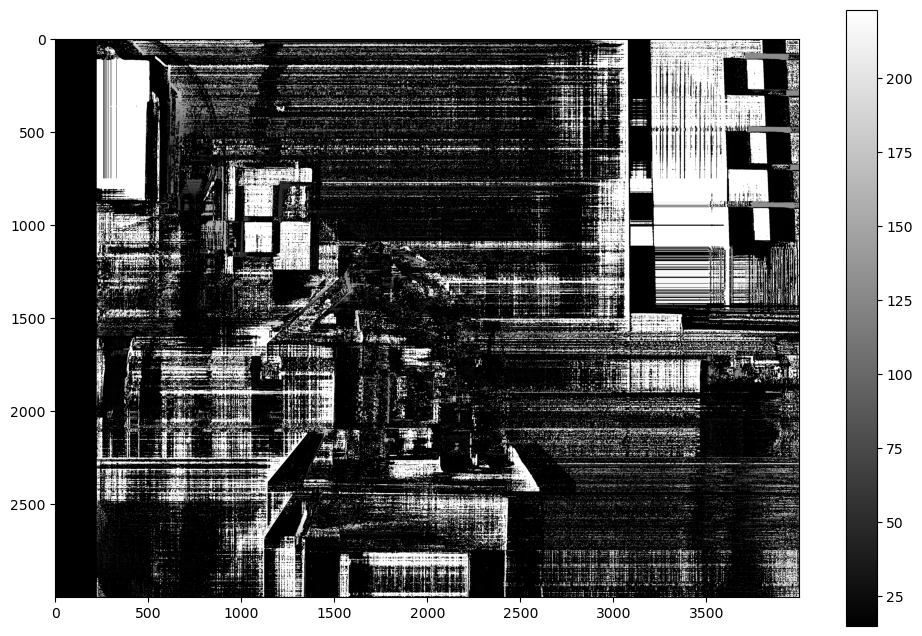

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


# Lade die beiden Bilder
imgL = cv.imread('Utils/Images/test/LINKS_V3.png', 0)
imgR = cv.imread('Utils/Images/test/RECHTS_V3.png', 0)

#print(imgL)
 
#imgL = cv.resize(imgL, None, fx=0.48, fy=0.34, interpolation=cv.INTER_CUBIC)
#imgR = cv.resize(imgR, None, fx=0.48, fy=0.34, interpolation=cv.INTER_CUBIC)

window_size = 3
min_disp = 16
nDispFactor = 14
num_disp = 16*nDispFactor-min_disp


stereo = cv.StereoSGBM_create(minDisparity = min_disp,
                              numDisparities = num_disp,
                              blockSize = window_size,
                              P1 = 8 * 3 * window_size**2,
                              P2 = 32 * 3 * window_size**2,
                              disp12MaxDiff = 1,
                              uniquenessRatio = 15,
                              speckleWindowSize = 0,
                              speckleRange = 2,
                              preFilterCap = 63,
                              mode = cv.STEREO_SGBM_MODE_SGBM_3WAY)

#compute
disparity = stereo.compute(imgL,imgR).astype(np.float32) / 16.0

# Normiere die Disparitätswerte auf den Bereich 0–255, damit sie als Bild gespeichert werden können
disparity_normalized = cv.normalize(disparity, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# Speicher die Disparitätskarte im Utils-Ordner
output_path = 'Utils/disparity_map.png'
cv.imwrite(output_path, disparity_normalized)


#Display
plt.figure(figsize=(12, 8))
plt.imshow(disparity, 'gray')
plt.colorbar()
plt.show()

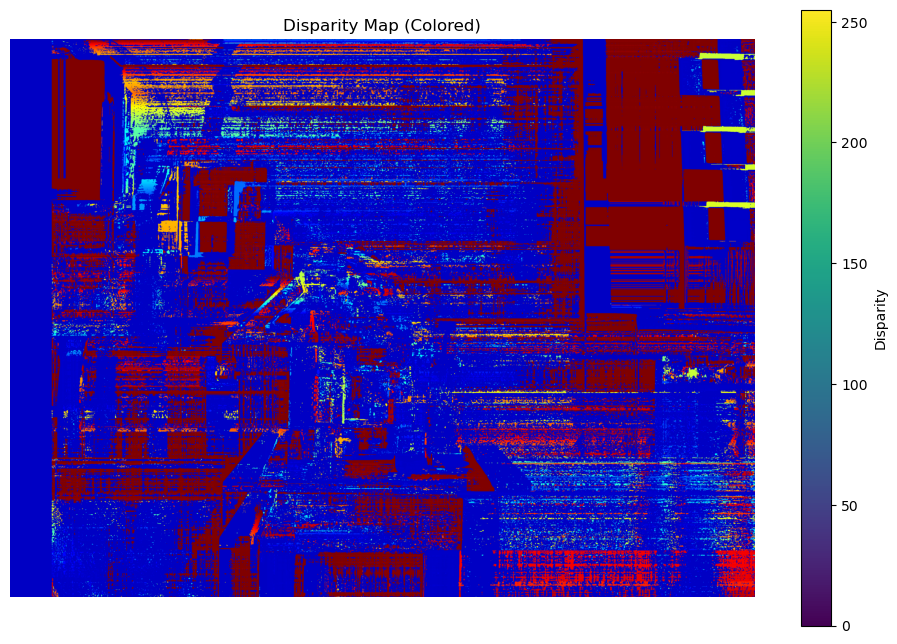

In [4]:
def show_disparity_with_color(disparity_map):
    # Umwandeln der Disparitätskarte in Farbe mit Jet-Colormap
    disparity_color = cv.applyColorMap((disparity_map * 255 / np.max(disparity_map)).astype(np.uint8), cv.COLORMAP_JET)

    # Anzeigen der Disparitätskarte mit Farbe
    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(disparity_color, cv.COLOR_BGR2RGB))
    plt.colorbar(label='Disparity')
    plt.title('Disparity Map (Colored)')
    plt.axis('off')
    plt.show()

# Berechnen der Disparitätskarte
disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Anzeigen der Disparitätskarte mit Farbe
show_disparity_with_color(disparity_map)

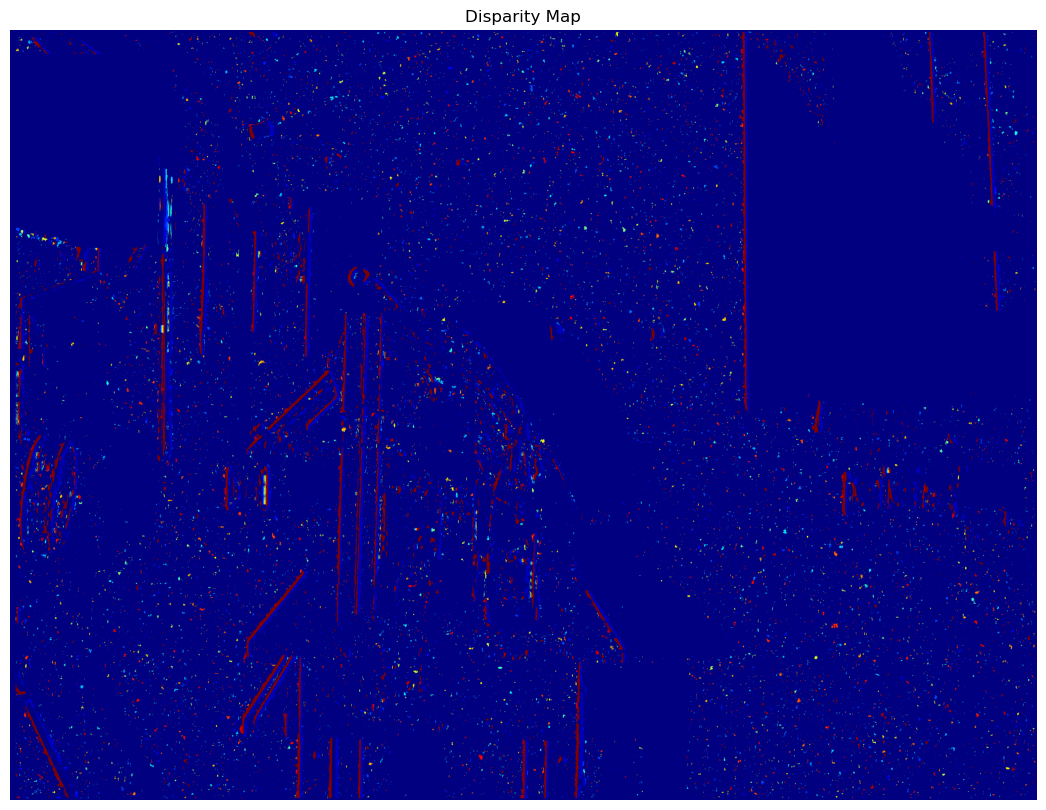

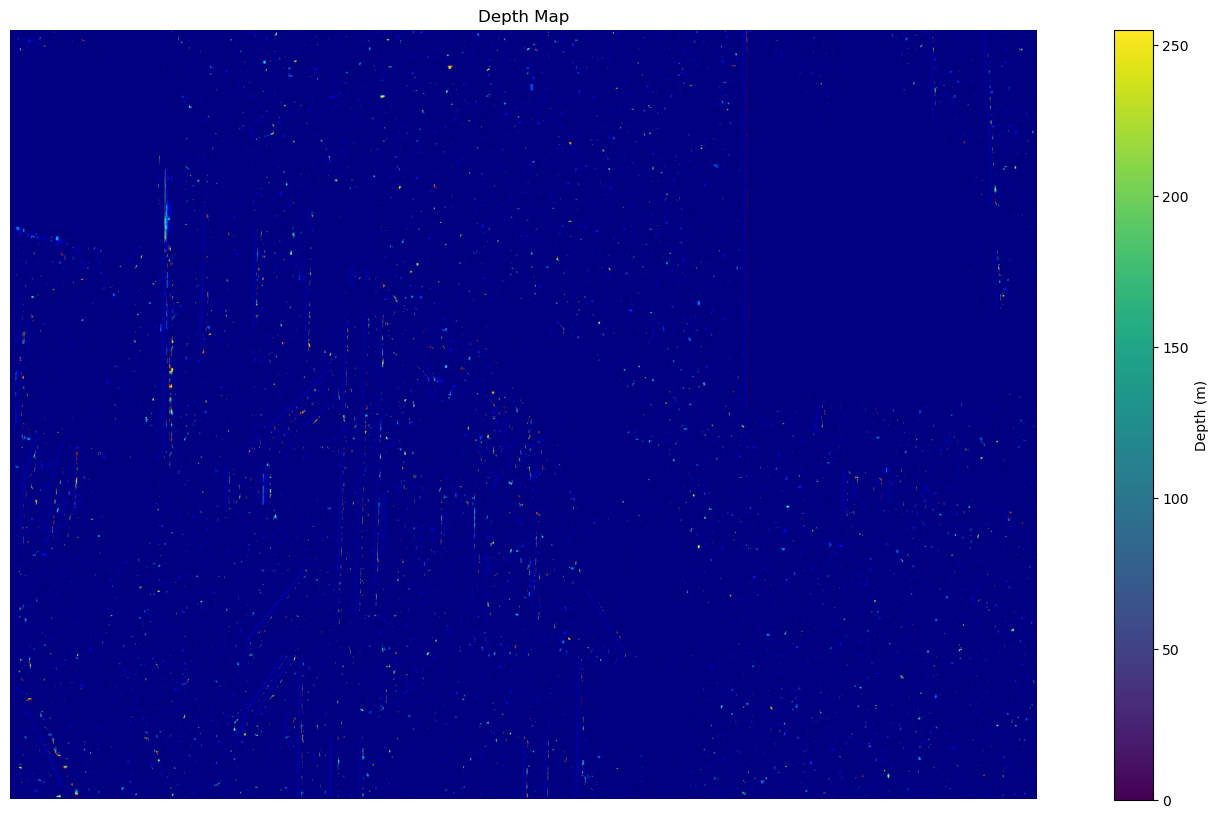

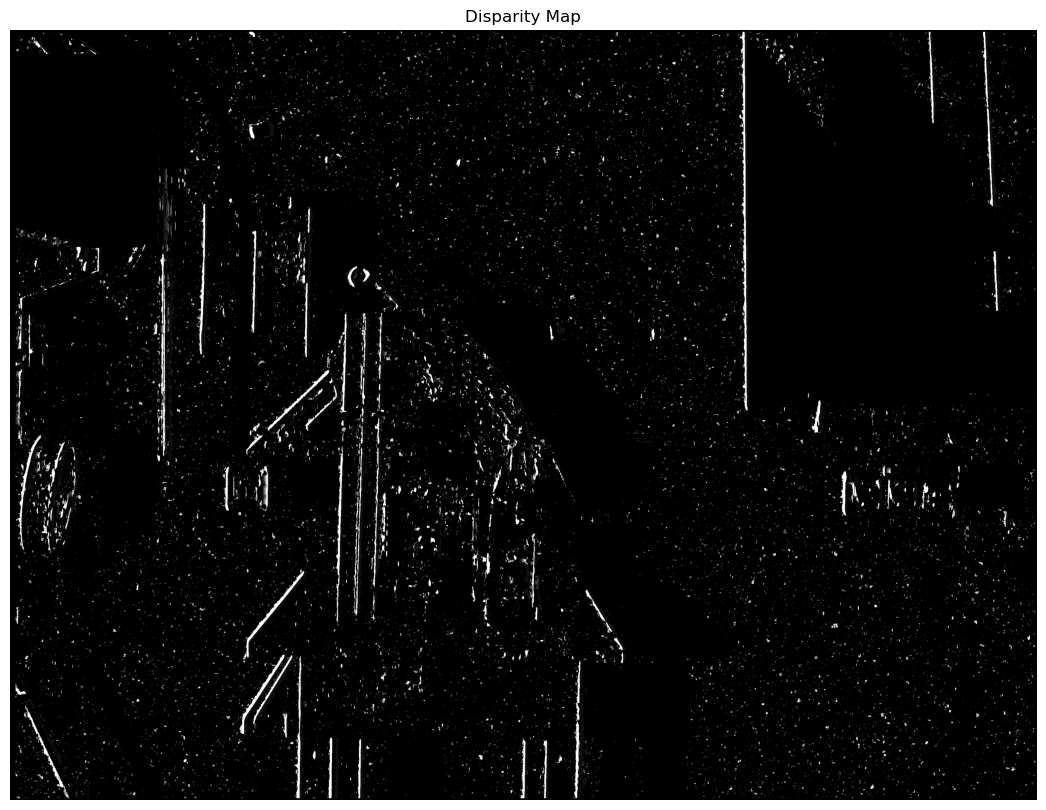

In [5]:
# StereoBM Konfiguration
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL, imgR)

# Baseline (Abstand zwischen den Kameras) und Brennweite der Kamera
baseline = 60  # Beispielwert, bitte anpassen
focal_length = 12  # Beispielwert, bitte anpassen

# Normalisieren der Disparitätskarte für die Anzeige
min_disp = disparity.min()
max_disp = disparity.max()
disparity_normalized = np.uint8(255 * (disparity - min_disp) / (max_disp - min_disp))

# Konvertieren der Disparitätskarte in eine Tiefenkarte
depth_map = np.zeros(disparity.shape, dtype=np.float32)
valid_pixels = disparity > 0
depth_map[valid_pixels] = (baseline * focal_length) / disparity[valid_pixels]

# Normalisieren der Tiefenkarte
depth_normalized = cv.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# Umwandeln der Disparitätskarte in eine Farbkarte
disparity_color = cv.applyColorMap(disparity_normalized, cv.COLORMAP_JET)
depth_color = cv.applyColorMap((depth_normalized * 255).astype(np.uint8), cv.COLORMAP_JET)

# Anzeigen der Disparitätskarte mit Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(cv.cvtColor(disparity_color, cv.COLOR_BGR2RGB))
plt.title('Disparity Map')
plt.axis('off')
plt.show()

# Anzeigen der Tiefenkarte mit Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(cv.cvtColor(depth_color, cv.COLOR_BGR2RGB))
plt.colorbar(label='Depth (m)')
plt.title('Depth Map')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(disparity_normalized, cmap='gray')
plt.title('Disparity Map')
plt.axis('off')
plt.show()

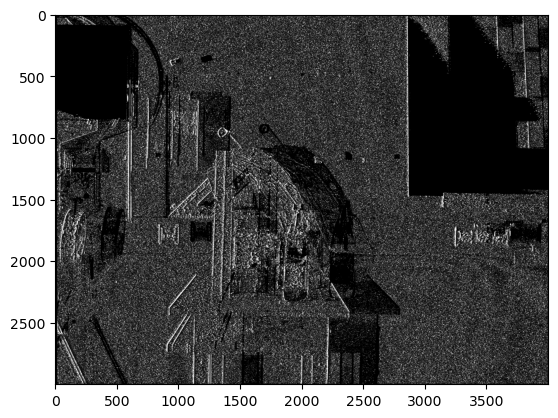

In [6]:
stereo = cv.StereoBM.create(numDisparities=16, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

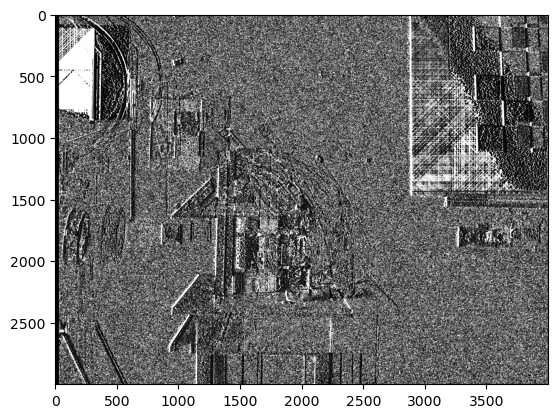

In [8]:
stereo = cv.StereoSGBM.create(minDisparity=16, numDisparities=16, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

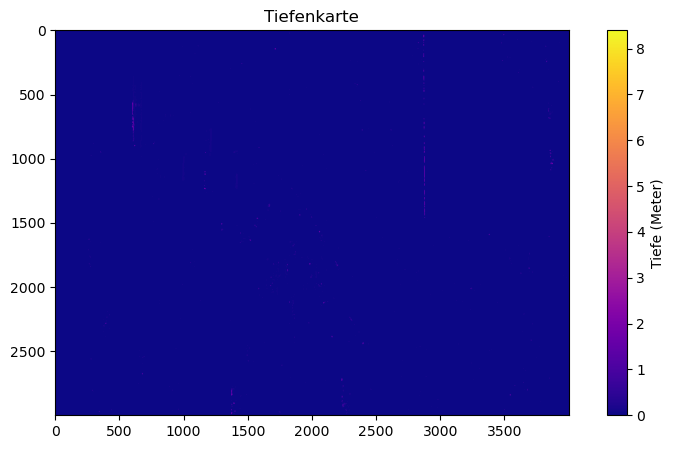

In [9]:
# Initialisiere den StereoBM-Algorithmus
stereo = cv.StereoBM_create(numDisparities=16*16, blockSize=15)

# Berechne die Disparität
disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Kameraparameter (Beispielwerte, müssen kalibriert werden)
focal_length = 70  # Brennweite in Pixeln
baseline = 0.06       # Stereobasis in Metern

# Tiefenkarte berechnen
depth_map = (focal_length * baseline) / (disparity + 1e-5)  # Vermeidung von Division durch Null

# Maskiere ungültige Werte (Disparität <= 0)
depth_map[disparity <= 0] = 0

# Zeige das Ergebnis
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.title('Tiefenkarte')
plt.colorbar(label='Tiefe (Meter)')
plt.show()

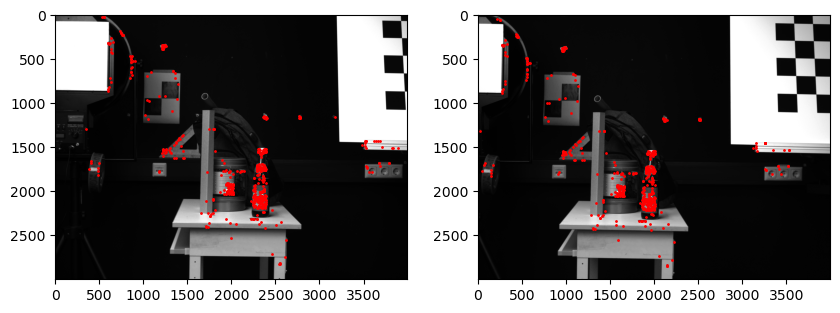

In [10]:
# Feature-Detektor und Matcher initialisieren
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Nur gute Matches behalten
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere Punktpaare
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Berechnung der Fundamental-Matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Auswahl nur der inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Tiefenberechnung hier einfügen (hier ist nur ein rudimentäres Beispiel)
# Weitere Schritte notwendig für vollständige SfM

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.scatter(pts1[:, 0], pts1[:, 1], color='r', s=1)
plt.subplot(1, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.scatter(pts2[:, 0], pts2[:, 1], color='r', s=1)
plt.show()

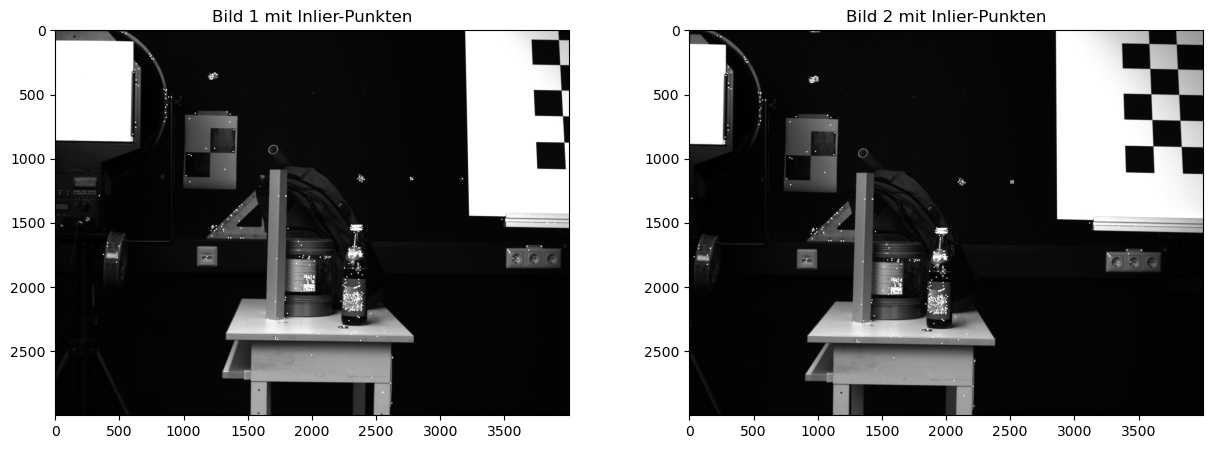

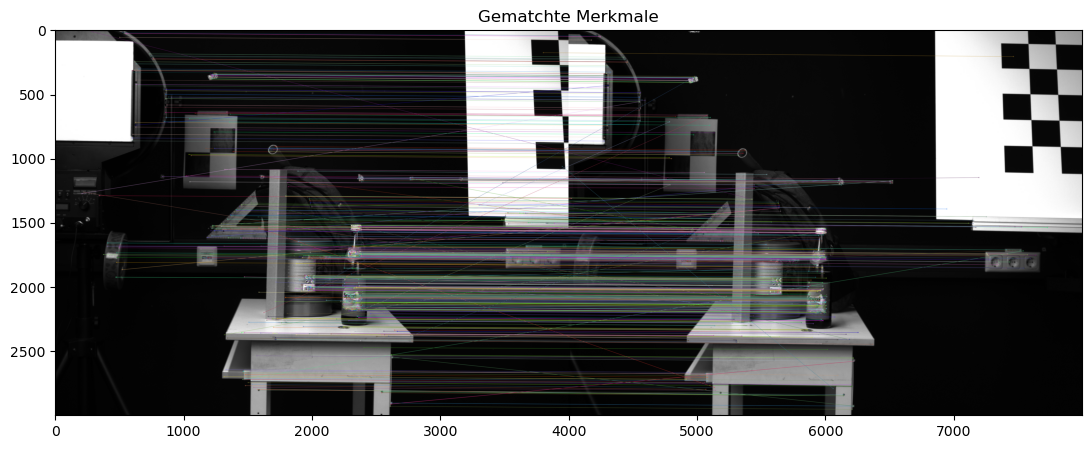

In [11]:
# Feature-Detektor (SIFT) und -Beschreiber initialisieren
sift = cv.SIFT_create()

# Merkmale und Beschreibungen berechnen
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

# Brute-Force-Matcher initialisieren
bf = cv.BFMatcher()

# Merkmale matchen
matches = bf.knnMatch(des1, des2, k=2)

# Nur die besten Matches behalten (Lowe's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere die Punktpaare
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Berechne die Fundamental-Matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Filtere nur die Inlier-Punkte heraus
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

# Visualisiere die Matches
img_matches = cv.drawMatches(imgL, kp1, imgR, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Zeichne die Inlier-Punkte auf den Bildern
for pt in pts1_inliers:
    cv.circle(imgL, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)
for pt in pts2_inliers:
    cv.circle(imgR, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

# Zeige die Ergebnisse
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.title('Bild 1 mit Inlier-Punkten')
plt.subplot(1, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.title('Bild 2 mit Inlier-Punkten')
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('Gematchte Merkmale')
plt.show()

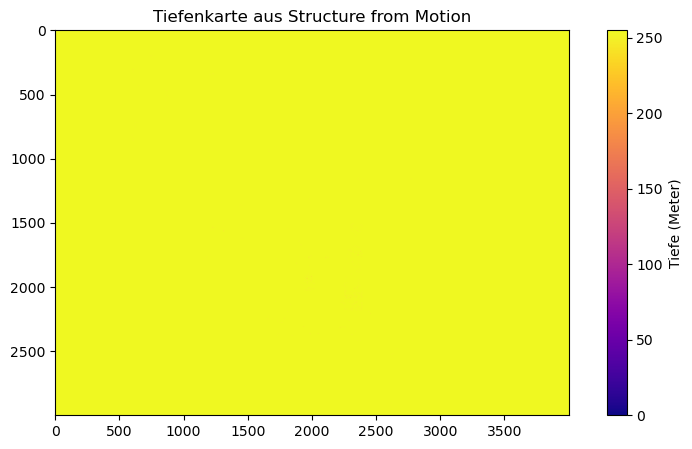

In [12]:
# Feature-Detektor (SIFT) und -Beschreiber initialisieren
sift = cv.SIFT_create()

# Merkmale und Beschreibungen berechnen
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Brute-Force-Matcher initialisieren
bf = cv.BFMatcher()

# Merkmale matchen
matches = bf.knnMatch(desL, desR, k=2)

# Lowe's Ratio Test, um nur die besten Matches zu behalten
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere die Punktpaare
ptsL = np.float32([kpL[m.queryIdx].pt for m in good_matches])
ptsR = np.float32([kpR[m.trainIdx].pt for m in good_matches])

# Berechne die Fundamental-Matrix
F, mask = cv.findFundamentalMat(ptsL, ptsR, cv.FM_RANSAC)

# Filtere nur die Inlier-Punkte heraus
ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

# Intrinsische Kameraparameter (angenommen oder aus Kalibrierung)
K = np.array([[1000, 0, imgL.shape[1]/2],
              [0, 1000, imgL.shape[0]/2],
              [0, 0, 1]])

# Essential Matrix aus Fundamental Matrix und Intrinsischen Parametern berechnen
E = K.T @ F @ K

# Dekomposition der Essential Matrix, um R und t zu erhalten
_, R, t, _ = cv.recoverPose(E, ptsL, ptsR, K)

# Baseline (Abstand zwischen den Kameras)
baseline = np.linalg.norm(t)

# Berechne Tiefeninformation für jeden Punkt
depth_map = np.zeros_like(imgL, dtype=np.float32)

# Iteriere über alle Punkte
for i in range(len(ptsL)):
    # Punkt-Koordinaten in Bild 1 und Bild 2
    ptL = ptsL[i]
    ptR = ptsR[i]
    
    # Triangulation der Punkte
    A = np.array([
        [ptL[0], 1],
        [ptR[0], 1]
    ])
    B = np.array([
        [ptL[1]],
        [ptR[1]]
    ])
    
    # Berechne die Tiefe (Tiefenkarte)
    depth = baseline / np.dot(np.linalg.inv(A), B)[0, 0]
    
    # Speichere die Tiefe im Depth-Map-Array
    depth_map[int(ptL[1]), int(ptL[0])] = depth

# Normalisiere die Tiefenkarte für die Darstellung
depth_map = cv.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
depth_map = np.uint8(depth_map)

# Zeige die Tiefenkarte an
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Tiefe (Meter)')
plt.title('Tiefenkarte aus Structure from Motion')
plt.show()

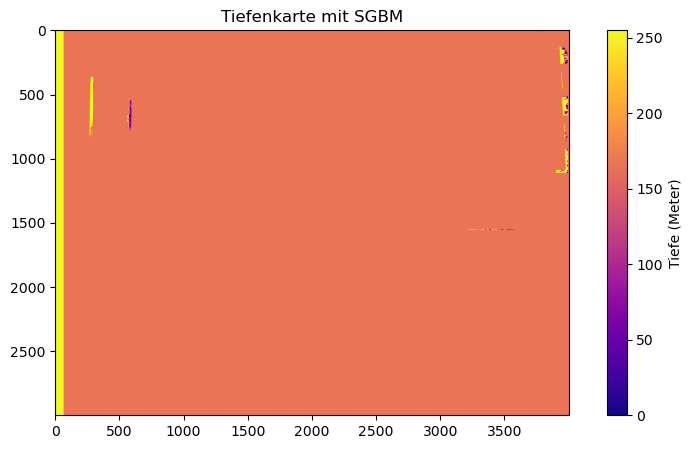

In [13]:
# SGBM-Disparitätsberechnung
#stereo = cv.StereoSGBM_create(minDisparity=3,
#                               numDisparities=128,  # Mehr Disparitäten für detailliertere Tiefenkarte
#                               blockSize=21,  # Größerer Block für genauere Disparitätsberechnung
#                               P1=200,  # Erhöhte Glättungskosten für eine glattere Oberfläche
#                               P2=800,  # Erhöhte Glättungskosten für eine glattere Oberfläche
#                               preFilterCap=63,  # Vorfilterungskappe für die Disparitäten
#                               uniquenessRatio=10)  # Einschränkung der Uniqueness-Constraint


# SGBM-Parameter einstellen
minDisparity = 3
numDisparities = 64  # Muss durch 16 teilbar sein
blockSize = 21  # Ungerade Zahl, typischerweise zwischen 3 und 11
P1 = 8 * 3 * blockSize ** 2
P2 = 32 * 3 * blockSize ** 2
disp12MaxDiff = 1  # Maximale Differenz in der Disparitätswerte zwischen benachbarten Pixeln
preFilterCap = 63  # Begrenzung der Vorfilterung der Disparitäten
uniquenessRatio = 10  # Maximale Unähnlichkeitsrate zwischen den besten und zweitbesten Disparitätskosten
speckleWindowSize = 100  # Maximale Größe des Bereichs, in dem die Disparitäten als Speckle betrachtet werden
speckleRange = 32  # Maximale Differenz zwischen den Disparitäten innerhalb eines zusammenhängenden Bereichs, um als Speckle betrachtet zu werden
mode = cv.StereoSGBM_MODE_SGBM  # Modus für die Disparitätsberechnung

# SGBM-Objekt erstellen
stereo = cv.StereoSGBM_create(minDisparity=minDisparity,
                               numDisparities=numDisparities,
                               blockSize=blockSize,
                               P1=P1,
                               P2=P2,
                               disp12MaxDiff=disp12MaxDiff,
                               preFilterCap=preFilterCap,
                               uniquenessRatio=uniquenessRatio,
                               speckleWindowSize=speckleWindowSize,
                               speckleRange=speckleRange,
                               mode=mode)

disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Umwandlung der Disparität in eine Tiefenkarte
baseline = 0.006  # Beispiel für die Baseline in Metern
depth_map = baseline / disparity

# Normalisierung der Tiefenkarte für die Darstellung
depth_map = cv.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
depth_map = np.uint8(depth_map)

# Anzeigen der Tiefenkarte
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Tiefe (Meter)')
plt.title('Tiefenkarte mit SGBM')
plt.show()